In [2]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/pheme/pheme-dataset.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
display(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,text,target
0,0,"Breaking: At least 10 dead, 5 injured after tO...",1
1,1,France: 10 people dead after shooting at HQ of...,1
2,2,Ten killed in shooting at headquarters of Fren...,1
3,3,BREAKING: 10 dead in shooting at headquarters ...,1
4,4,Reuters: 10 people shot dead at headquarters o...,1
...,...,...,...
1700,2397,Police confirm that #sydneysiege is finally ov...,1
1701,2398,"Sad end: 2 people are dead, 3 in serious condi...",1
1702,2399,Seven people reportedly taken away on stretche...,1
1703,2400,BREAKING: CNN: Sydney police storm cafe. 2 con...,1


In [ ]:
print(df.shape)
df.isna().sum()

(1705, 3)


Unnamed: 0    0
text          0
target        0
dtype: int64

,text,target
0,Secret Prince Show Rumored for Toronto Tonight...,0
1,"BREAKING: Performance art piece ""Soon To Be Di...",0
2,Stay with us for LIVE coverage on the active s...,1
3,Tragedy mounts as soldier shot this AM dies of...,1
4,Flag in window of Sydney Lindt cafe not an ISI...,1
...,...,...
1700,Is #Prince planning a secret show in #Toronto ...,0
1701,UPDATE: Reports a gunman is requesting to spea...,1
1702,"Ottawa Police Service: There were ""numerous gu...",0
1703,An 11-month old baby is among the hostages at ...,1


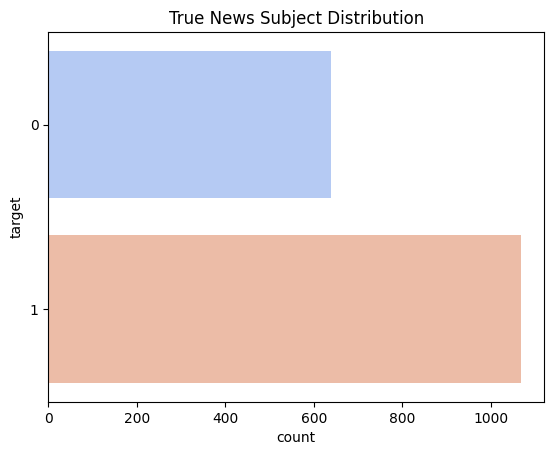

In [ ]:
from sklearn.utils import shuffle

df = df[['text','target']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="target", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1705 non-null   object
 1   target  1705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


In [ ]:
df.drop_duplicates(subset=['text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1699 non-null   object
 1   target  1699 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


In [ ]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.875)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (1189, 2)
valset size: (170, 2)
testset size: (340, 2)


In [ ]:
from sklearn.utils import resample
def upsample_data(df):
    df_majority = df[df.target == 0]
    df_minority = df[df.target == 1]
    if len(df_majority) >= len(df_minority):
      df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
      df_upsampled = pd.concat([df_majority, df_minority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
      df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=42)
      df_upsampled = pd.concat([df_minority, df_majority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_upsampled

train_df= upsample_data(train_df)
val_df= upsample_data(val_df)

In [ ]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 1480
valset size: 184
testset size:  340


In [ ]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
11 confirmed dead, Francois Hollande to visit scene of attack - latest from Paris: http://t.co/7N7uvClhWY http://t.co/EgmxARAdEP

tokens: 
['[CLS]', '11', 'confirmed', 'dead', ',', 'francois', 'holland', '##e', 'to', 'visit', 'scene', 'of', 'attack', '-', 'latest', 'from', 'paris', ':', 'http', ':', '/', '/', 't', '.', 'co', '/', '7', '##n', '##7', '##u', '##vc', '##l', '##h', '##wy', 'http', ':', '/', '/', 't', '.', 'co', '/', 'e', '##gm', '##xa', '##rade', '##p', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([  101,  2340,  4484,  2757,  1010,  8173,  7935,  2063,  2000,  3942,
         3496,  1997,  2886,  1011,  6745,  2013,  3000,  1024,  8299,  1024,
         1013,  1013,  1056,  1012,  2522,  1013,  1021,  2078,  2581,  2226,
        25465,  2140,  2232, 18418,  8299,  1024,  1013,  1013,  1056,  1012,
         2522,  1013,  1041, 21693, 18684, 13662,  2361,   102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [ ]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
# dropout_rate = 0.1
model = BertForSequenceClassification.from_pretrained(
    # PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS, hidden_dropout_prob=dropout_rate)
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
NUM_EPOCHS = 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(trainloader) * NUM_EPOCHS)

start_time = time.time()

best_val_acc = 0.0
best_model = None


for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

        scheduler.step()

    # model.eval()
    # val_loss = 0.0
    # val_acc = 0.0
    # with torch.no_grad():
    #     for data in valloader:
    #         tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
    #         outputs = model(input_ids=tokens_tensors, 
    #                         token_type_ids=segments_tensors, 
    #                         attention_mask=masks_tensors, 
    #                         labels=labels)
    #         loss = outputs[0]
    #         logits = outputs[1]
    #         _, pred = torch.max(logits.data, 1)
    #         val_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
    #         val_loss += loss.item()

    # val_acc /= len(valloader)
    # val_loss /= len(valloader)

    # print(f"Validation accuracy: {val_acc}, Validation loss: {val_loss}")

    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     best_model = model.state_dict()
    #     torch.save(best_model, './best_model.pth')
    # model.train()
end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.9176470588235294
Precision :  0.9285714285714286
Recall :  0.9525862068965517
F1 :  0.9404255319148935
G-mean: 0.8959029421410052
Training time:  68.85924243927002
Inference time:  1.5094356536865234
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       108
           1       0.93      0.95      0.94       232

    accuracy                           0.92       340
   macro avg       0.91      0.90      0.90       340
weighted avg       0.92      0.92      0.92       340



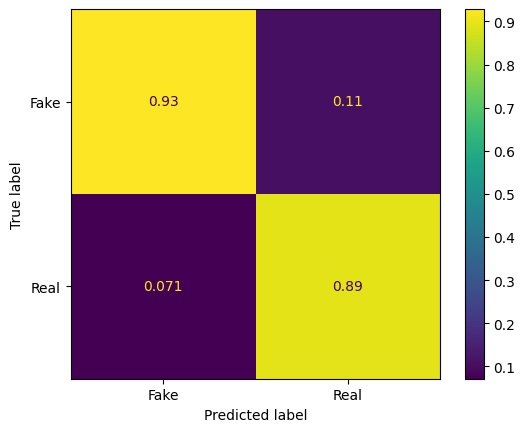

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()